## BBM 409 - Programming Assignment 1


###  Salih Eren, Yüzbaşıoğlu, 2220356040

## Understanding Perceptron Learning Algorithm (100 points +5 points)

This notebook explores the Perceptron Learning Algorithm for a binary classification task using the Banknote Authentication Dataset. The goal is to classify banknotes as either authentic (class 1) or fake (class 0) based on four features: variance, skewness, kurtosis, and entropy of the banknote image with 1,372 samples.  The notebook covers implementation of the algorithm from scratch, performance evaluation using various metrics, and visualization of the decision boundary.

### 1. Data Loading and Exploration (5 points)

The Banknote Authentication Dataset is loaded from the UCI repository using the `ucimlrepo` library.  Initial exploration includes examining dataset size, features, target variables, summary statistics, and checking for missing values.

In [40]:
## Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [41]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
banknote_authentication = fetch_ucirepo(id=267) 
  
# data (as pandas dataframes) 
# Features and target variables
X = banknote_authentication.data.features 
Y = banknote_authentication.data.targets 
  
# metadata 
print(banknote_authentication.metadata) 
  
# variable information 
print(banknote_authentication.variables) 


{'uci_id': 267, 'name': 'Banknote Authentication', 'repository_url': 'https://archive.ics.uci.edu/dataset/267/banknote+authentication', 'data_url': 'https://archive.ics.uci.edu/static/public/267/data.csv', 'abstract': 'Data were extracted from images that were taken for the evaluation of an authentication procedure for banknotes.', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1372, 'num_features': 4, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2012, 'last_updated': 'Fri Feb 16 2024', 'dataset_doi': '10.24432/C55P57', 'creators': ['Volker Lohweg'], 'intro_paper': None, 'additional_info': {'summary': 'Data were extracted from images that were taken from genuine and forged banknote-like specimens.  For digitization, an industrial camera usually used for print inspection was used. The final im

In [42]:
## Read the regression data and transform it into a Numpy array collection.
## (See pandas and numpy functions)
numpy_X = X.to_numpy()
numpy_y = Y.to_numpy()
column_names = X.columns
numpy_X, numpy_y, column_names

(array([[  3.6216 ,   8.6661 ,  -2.8073 ,  -0.44699],
        [  4.5459 ,   8.1674 ,  -2.4586 ,  -1.4621 ],
        [  3.866  ,  -2.6383 ,   1.9242 ,   0.10645],
        ...,
        [ -3.7503 , -13.4586 ,  17.5932 ,  -2.7771 ],
        [ -3.5637 ,  -8.3827 ,  12.393  ,  -1.2823 ],
        [ -2.5419 ,  -0.65804,   2.6842 ,   1.1952 ]]),
 array([[0],
        [0],
        [0],
        ...,
        [1],
        [1],
        [1]]),
 Index(['variance', 'skewness', 'curtosis', 'entropy'], dtype='object'))

In [43]:
## Explore the dataset (e.g., size, features, target variables, summary statistics).
## Check for any missing values and handle them if necessary.
print(X.shape)
# Summary statistics
print("\nSummary statistics:")
X.describe()

(1372, 4)

Summary statistics:


,variance,skewness,curtosis,entropy
count,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657
std,2.842763,5.869047,4.310030,2.101013
min,-7.042100,-13.773100,-5.286100,-8.548200
25%,-1.773000,-1.708200,-1.574975,-2.413450
50%,0.496180,2.319650,0.616630,-0.586650
75%,2.821475,6.814625,3.179250,0.394810
max,6.824800,12.951600,17.927400,2.449500


In [44]:
# Check for missing values
print("\nMissing values:")
X.isnull().sum()


Missing values:


variance    0
skewness    0
curtosis    0
entropy     0
dtype: int64

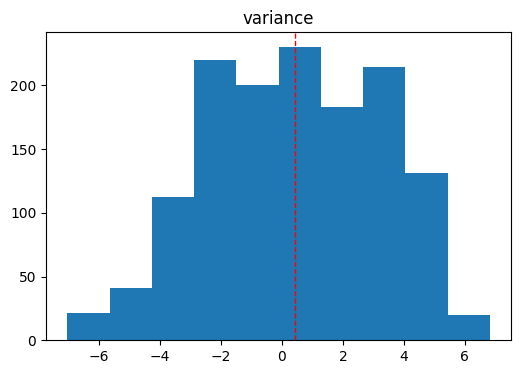

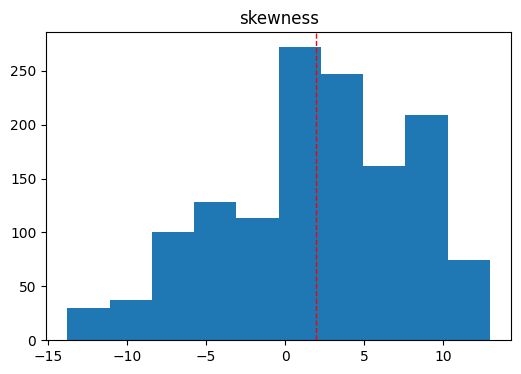

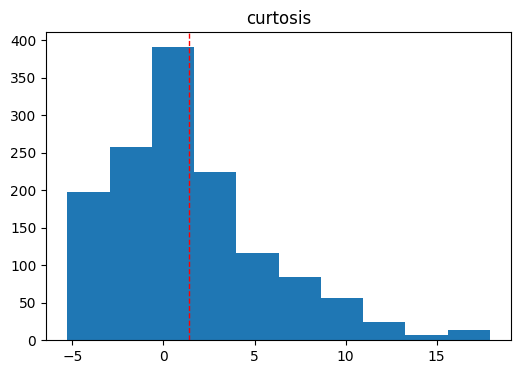

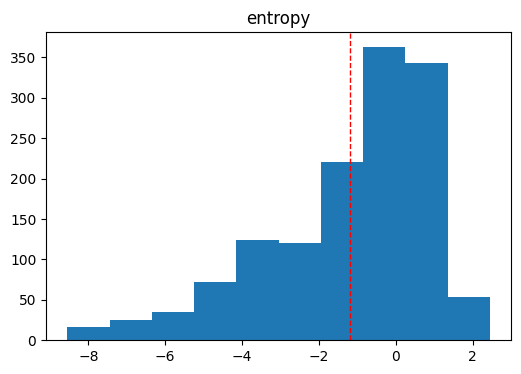

In [45]:
# print plot for every feature
for i in range(X.shape[1]):
    plt.figure(figsize=(6, 4)) 
    plt.hist(numpy_X[:,i])
    plt.title(column_names[i])
    plt.axvline(numpy_X[:,i].mean(), color='r', linestyle='dashed', linewidth=1)
    plt.show()

Looks like columns have distributions similar to a normal distribution. With some skewness and non-zero means.

In [46]:
# 1 vs 0 in class
print("\nClass distribution:")
Y.value_counts()


Class distribution:


class
0        762
1        610
Name: count, dtype: int64

### 2. Data Preprocessing (5 points)

#### Feature Scaling Techniques:
Feature scaling is important for many machine learning algorithms, especially those based on distance metrics (e.g., k-nearest neighbors, support vector machines) and gradient descent optimization (e.g., linear regression, logistic regression).

Some common feature scaling techniques include:

1. **Standardization (Z-score normalization):** It scales the features to have a mean of 0 and a standard deviation of 1.
2. **Min-Max Scaling:** It scales the features to a fixed range, typically between 0 and 1.
3. **Robust Scaling:** It scales the features based on percentiles, making it robust to outliers.


The features have significantly different ranges. For example, the standard deviations vary from around 2.1 to 5.9, and the min and max values also differ considerably across features.

The features are approximately normally distributed, though some are skewed or have different kurtosis values. This suggests that Standardization (Z-score normalization) is appropriate, as it normalizes data to have a mean of 0 and a standard deviation of 1, which works well for distributions close to normal.

For null values, since there are none, we don't need to worry about imputation or removal.

In [47]:
# Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numpy_X)
# add bias
X_scaled = np.insert(X_scaled, 0, 1, axis=1)
## for perceptron need to update classes 0 to be -1
numpy_y[numpy_y == 0] = -1

#### Training and Validation Split
1. Models with high variance (overfitting) will perform well on the training data but poorly on unseen data. By evaluating the model on a validation set, one can detect overfitting and adjust the model accordingly.
2. Evaluating the model on unseen data checks basically whether the model is useful for new data or not. If the model performs well on unseen data, it suggests that the model has learned the underlying patterns in the data and can generalize well to new data.

In [48]:
# Split the dataset into training and testing sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, numpy_y, test_size=0.2, random_state=1453)
# Print the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Y_train:", y_train.shape)
print("Shape of Y_test:", y_test.shape)

Shape of X_train: (1097, 5)
Shape of X_test: (275, 5)
Shape of Y_train: (1097, 1)
Shape of Y_test: (275, 1)


### 3. Implementing Perceptron for Binary Classification (20 points)

The Perceptron Learning Algorithm is implemented from scratch.  The core components are the `inference` function, which calculates the weighted sum of inputs, and the `update` function, which adjusts the weights based on misclassifications. The algorithm is well-suited for this binary classification task, especially after feature scaling, as it aims to find a linear separating hyperplane between the two classes.

In [49]:
## Implement Percepton Learning Algorithm
def inference(w,x):
    return w.T @ x
def update(w, x, t, lr):
    w += lr * t * x

With low learning rate would update it's weights very slowly causing slow convergence also it might not converge to the optimal solution. With high learning rate, it might overshoot the optimal solution and might not converge. But for this perceptron algorithm actually high learning rate is not a problem because important part is the ratio of the weights. So it will converge to the optimal solution with high learning rate as well, just with high values.

If the data is linearly separable, the perceptron algorithm is guaranteed to converge to the optimal solution. So having as many epochs to reach the optimal solution is important. However, if the data is not linearly separable, the perceptron algorithm will not converge, and the number of epochs will not affect the training process.

In [50]:
# Accuracy etc. implementation
def calMatrice(y_true, y_pred):
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    # TN, FP, FN, TP
    TN = np.sum((y_true == -1) & (y_pred == -1))
    FP = np.sum((y_true == -1) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == -1))
    TP = np.sum((y_true == 1) & (y_pred == 1))
    return TN, FP, FN, TP
def accuracy(y_true, y_pred):
    TN, FP, FN, TP = calMatrice(y_true, y_pred)
    return (TP + TN) / (TP + TN + FP + FN)

#### Train the Perceptron

In [51]:
## Train the Perceptron model on the training set.
def trainModel(X_train,y_train,epochs = 1000, lr = 0.01,seed = 1454):
    np.random.seed(seed)
    w = np.random.rand(X_train.shape[1])
    print("Initial weights:", w)
    for epoch in range(epochs):
        for i in range(X_train.shape[0]):
            x = X_train[i].T
            t = y_train[i]
            y = 1 if inference(w, x) > 0 else -1
            if t != y:
                update(w, x, t, lr)
    print("Final weights:", w)
    return w
w = trainModel(X_train,y_train)

Initial weights: [0.89579137 0.08949383 0.56989609 0.92702928 0.74793501]
Final weights: [-0.17420863 -0.373421   -0.37089647 -0.3495088   0.00377999]


#### Prediction on Training Data

In [52]:
# Predicting on the training data
y_pred_train = np.array([1 if inference(w, x) > 0 else -1 for x in X_train])
accuracy_train = accuracy(y_train, y_pred_train)
print("Training accuracy:", accuracy_train)

Training accuracy: 0.9890610756608933


### 4. Evaluating Perceptron for Binary Classification (25 points)

#### Prediction on Validation Data

In [53]:
## Evaluate the model's performance on the test set by calculating accuracy.
y_pred_test = np.array([1 if inference(w, x) > 0 else -1 for x in X_test])
accuracy_test = accuracy(y_test, y_pred_test)
print("Testing accuracy:", accuracy_test)

Testing accuracy: 0.9927272727272727


Answer the Guiding Questions:
1. What does accuracy tell us about the performance of the model?
2. Why is accuracy sometimes not enough, especially in cases where the data is imbal-
anced? Explain a scenario where a high accuracy might be misleading.1

Answers:
1) Accuracy tells us the proportion of correctly classified instances. It is mostly a good metric for balanced datasets.

2) Accuracy might not be enough when the dataset is imbalanced. For instance a dataset with %99 of the instances belonging to class A and %1 of the instances belonging to class B. A model that just randomly selects class A %99 of the time would have %99 accuracy. However, it would be a terrible model. In such cases, precision, recall, F1 score, ROC-AUC, etc. are better metrics to evaluate the model.

Several metrics are implemented from scratch to evaluate the model's performance:<br>
- **Accuracy:**  The proportion of correctly classified samples.<br>
- **Precision:** The proportion of true positives among all predicted positives.<br>
- **Recall:**  The proportion of true positives among all actual positives.<br>
- **F1-score:** The harmonic mean of precision and recall.

In [54]:
def precision(y_true, y_pred):
    TN, FP, FN, TP = calMatrice(y_true, y_pred)
    return TP / (TP + FP)
def recall(y_true, y_pred):
    TN, FP, FN, TP = calMatrice(y_true, y_pred)
    return TP / (TP + FN)
def f1_score(y_true, y_pred):    
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * p * r / (p + r)
def calculate_metrics(y_true, y_pred):
    accuracy2 = accuracy(y_true, y_pred)
    precision2 = precision(y_true, y_pred)
    recall2 = recall(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy2, precision2, recall2, f1

# Calculate and print metrics
accuracy_train, precision_train, recall_train, f1_train = calculate_metrics(y_train.flatten(), y_pred_train)

print(f"Training Accuracy: {accuracy_train}")
print(f"Training Precision: {precision_train}")
print(f"Training Recall: {recall_train}")
print(f"Training F1 Score: {f1_train}")

Training Accuracy: 0.9890610756608933
Training Precision: 0.9919191919191919
Training Recall: 0.9839679358717435
Training F1 Score: 0.987927565392354


Answer the Guiding Questions:
1. In what types of problems is precision more important than recall? Give an example
scenario where high precision is desirable but low recall might be acceptable.
2. In what cases is recall more critical? Discuss an example where missing true positives
is more harmful than having false positives.
3. When is the F1 score a better measure than accuracy? Explain why balancing
precision and recall is important in some contexts.
4. What are the limitations of using F1 score alone?

Answers:
1. Precision is especially important when the cost of false positives is high. For example, in a spam detection system, we want to make sure that an email is spam only if we are very sure about it. In this case, high precision is desirable, but low recall might be acceptable.
2. Recall is more important when detecting something is very important. For instance, in a cancer detection system, we want to make sure that we detect all cancer patients, even if we have some false positives. It is most important to not miss any true positives.
3. As said before accuracy becomes obselete when classes are imbalanced and F1 score is a better measure. F1 score balances precision and recall, and it is especially useful when the cost of false positives and false negatives are very different.
4. F1 score is a harmonic mean of precision and recall. It is a better measure than accuracy when classes are imbalanced. However, it does not tell us the proportion of correctly classified instances. It is a good measure when we want to balance precision and recall.

### 5. Visualization of the Hyperplane (40 + 5 points)

In this section, you will explore how the Perceptron Learning Algorithm forms the de-
cision boundary (or hyperplane) that separates the two classes. To be able to do that
you will reduce the feature space to two dimensions, train the Perceptron on the selected
features, and visualize the hyperplane. The goal is to understand how the Perceptron
changes the decision boundary as the data changes, and how it adapts based on the
features used.

#### Step 1: Feature Selection Using Correlation Analysis (10 points)

1. Correlation Analysis: One effective way to reduce the number of features is by
analyzing the correlation between them. Highly correlated features may provide re-
dundant information, so you can select two less correlated features for visualization.
2. Compute the correlation matrix: Analyze the relationship between the four features
(variance, skewness, kurtosis, and entropy) to identify pairs of features with low
correlation.

<Axes: >

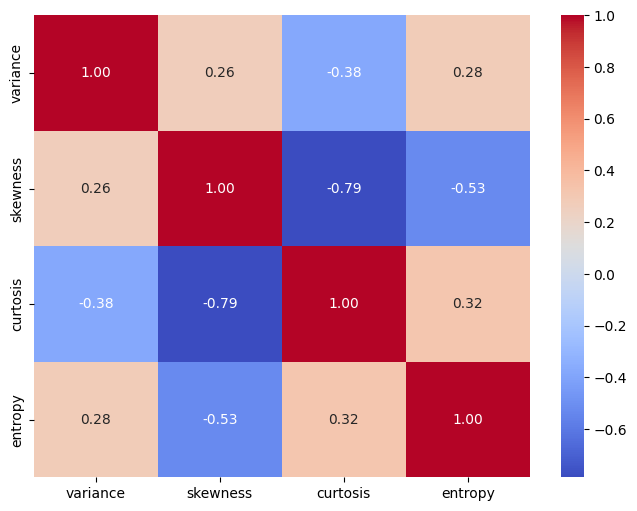

In [55]:
# Compute the correlation matrix
correlation_matrix = X.corr()
# Display the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

3. Choose two features: Based on the correlation analysis, select two features that are
least correlated (e.g., variance and skewness) to visualize the Perceptron’s decision
boundary.

## Deleting Skewness and Kurtosis columns since they are highly correlated with each other and with variance and entropy.

In [56]:
# Select two features
# Select these features from the original feature set
# delete the third and fourth columns from X_scaled
X_deleted = np.delete(X_scaled, [2, 3], axis=1)
# Split the selected features into training and validation sets if not done yet
X_train_deleted, X_test_deleted, y_train_deleted, y_test_deleted = train_test_split(X_deleted, numpy_y, test_size=0.2, random_state=1453)
print(X_train_deleted.shape)

(1097, 3)


#### Step 2: Train the Perceptron on Selected Features (10 points)

1. Retrain the Perceptron: After selecting two features, train the Perceptron using
only these two features. Use the same training and evaluation process as before,
but now the model will work in a two-dimensional feature space.

In [57]:
## Train the Perceptron model on the training set.
wd = trainModel(X_train_deleted, y_train_deleted)
# Predicting on the training data
y_pred_train_deleted = np.array([1 if inference(wd, x) > 0 else -1 for x in X_train_deleted])
accuracy_train_deleted = accuracy(y_train_deleted, y_pred_train_deleted)
print("Training Accuracy:", accuracy_train_deleted)

Initial weights: [0.89579137 0.08949383 0.56989609]
Final weights: [ 0.00579137 -0.02071326 -0.00407007]
Training Accuracy: 0.813126709206928


2. Visualize the decision boundary (hyperplane): Once the Perceptron is trained, plot
the decision boundary (hyperplane) to see how the Perceptron separates the two
classes in 2D.

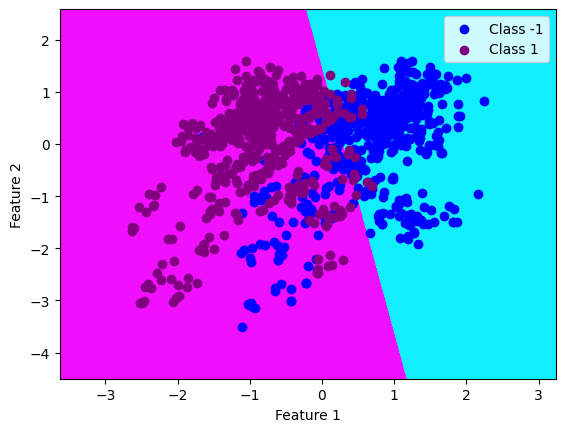

In [58]:
# Function to plot the decision boundary for model with 2 dimensions
def plot_decision_boundary(X, y, model):
    # plot class 1 as blue points
    classOne = (y == 1).reshape(-1)
    classMinusOne = (y == -1).reshape(-1)

    # plot the decision boundary
    min1, max1 = X[:, 1].min()-1, X[:, 1].max()+1
    min2, max2 = X[:, 2].min()-1, X[:, 2].max()+1
    # define the x and y scale
    x1grid = np.arange(min1, max1, 0.01)
    x2grid = np.arange(min2, max2, 0.01)
    # create all of the lines and rows of the grid
    xx, yy = np.meshgrid(x1grid, x2grid)
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape(-1,1), r2.reshape(-1,1)
    # horizontal stack vectors to create x1,x2 and bias
    grid = np.hstack((np.ones((r1.shape[0],1)), r1, r2))
    # make predictions
    predictions = np.array([1 if inference(model, x) > 0 else -1 for x in grid])
    # reshape the predictions back into a grid
    zz = predictions.reshape(xx.shape)
    # plot the grid of x, y and z values as a surface
    plt.contourf(xx, yy, zz, cmap='cool')  

    # Scatter plots for each class with cool colors
    plt.scatter(X[classMinusOne][:, 1], X[classMinusOne][:, 2], color='blue', label='Class -1')  # Set color to purple for Class -1
    plt.scatter(X[classOne][:, 1], X[classOne][:, 2], color='purple', label='Class 1')      # Set color to blue for Class 1
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()
# Plot the decision boundary using the selected features and trained model
plot_decision_boundary(X_train_deleted, y_train_deleted, wd)


#### Step 3: Experiment with Different Features (10 points)

After visualizing the decision boundary for one pair of features, try selecting different
combinations of features (e.g., variance and entropy) and retrain the Perceptron. Compare
how the hyperplane changes with different features. This helps in understanding how the
Perceptron’s decision-making process adapts to different feature sets.

Answer the guiding
questions:
1. How does the decision boundary change when you use different pairs of features?
2. Can you find a pair of features that leads to better separation between the two
classes?

Answers:
1. Looking at below graphs we can see the shape of graphs changes significantly between different pairs of features. Which then affects the accuracy of ideal decision boundary. You can see some combinations of features are more separable than others with accuracy changing from %45 to %84.
2. The pair of features that leads to better separation between the two classes is skewness and entropy. The decision boundary seperates the classes better than other pairs of features.

Initial weights: [0.13945452 0.0903189  0.46714064]
Final weights: [ 0.01945452 -0.00441079  0.00253269]
Training Accuracy without features 1 and 2: 0.45487693710118504


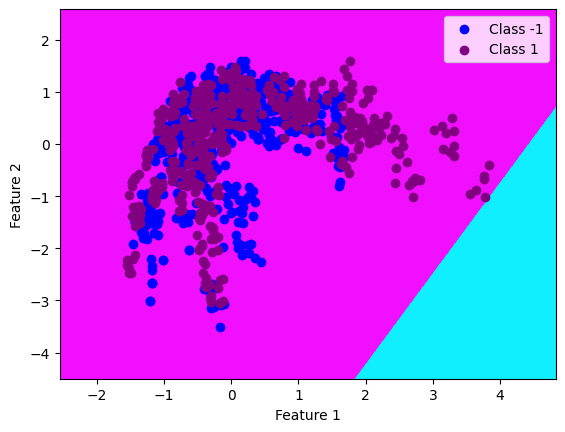

Initial weights: [0.13945452 0.0903189  0.46714064]
Final weights: [ 0.00945452 -0.01892674 -0.01050944]
Training Accuracy without features 1 and 3: 0.7538742023701003


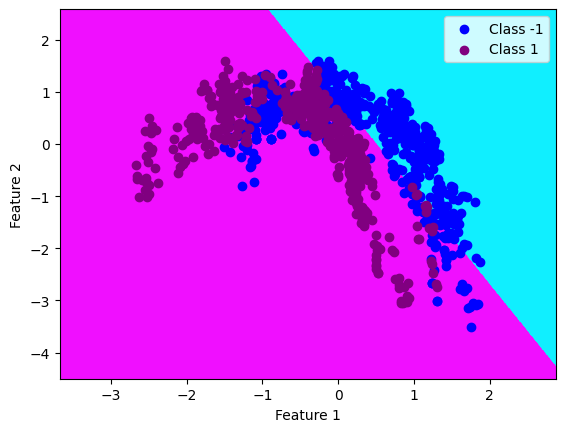

Initial weights: [0.13945452 0.0903189  0.46714064]
Final weights: [-0.00054548 -0.00598432 -0.00718352]
Training Accuracy without features 1 and 4: 0.6435733819507748


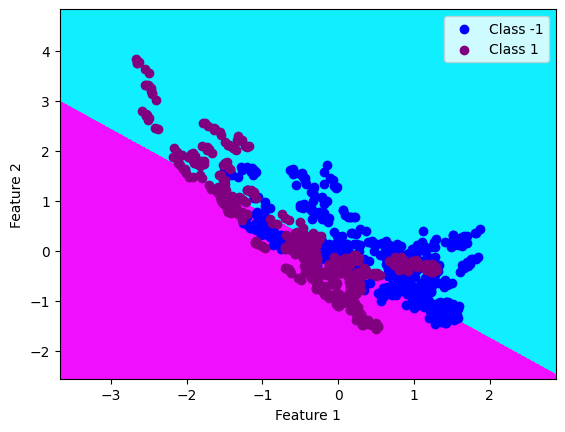

Initial weights: [0.13945452 0.0903189  0.46714064]
Final weights: [-0.00054548 -0.03217611 -0.00025897]
Training Accuracy without features 2 and 3: 0.853236098450319


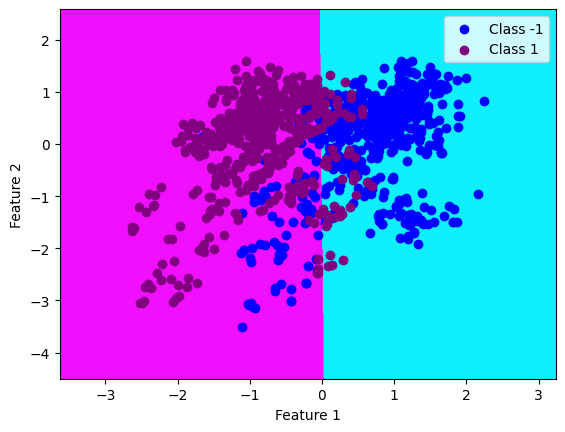

Initial weights: [0.13945452 0.0903189  0.46714064]
Final weights: [ 0.00945452 -0.03013865 -0.00463622]
Training Accuracy without features 2 and 4: 0.8240656335460347


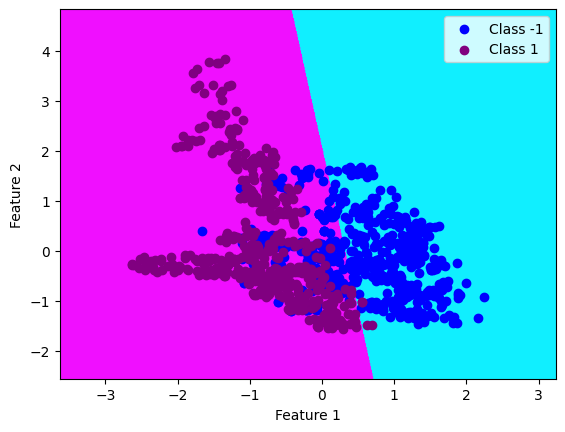

Initial weights: [0.13945452 0.0903189  0.46714064]
Final weights: [ 0.00945452 -0.02158845 -0.00211502]
Training Accuracy without features 3 and 4: 0.7948951686417502


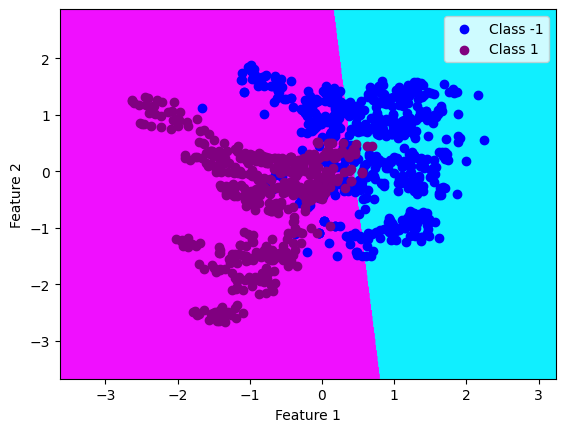

In [59]:
# train on every possible combination of two features except bias
for i in range(1,X_scaled.shape[1]):
    for j in range(i+1, X_scaled.shape[1]):
        X_deleted = np.delete(X_scaled, [i, j], axis=1)
        X_train_deleted, X_test_deleted, y_train_deleted, y_test_deleted = train_test_split(X_deleted, numpy_y, test_size=0.2, random_state=1453)
        wd = trainModel(X_train_deleted, y_train_deleted,seed=1351)
        y_pred_train_deleted = np.array([1 if inference(wd, x) > 0 else -1 for x in X_train_deleted])
        accuracy_train_deleted = accuracy(y_train_deleted, y_pred_train_deleted)
        print(f"Training Accuracy without features {i} and {j}:", accuracy_train_deleted)
        plot_decision_boundary(X_train_deleted, y_train_deleted, wd)

#### Bonus Step 4: Incrementally Add Data (+ 5 points)

1. Visualizing Incremental Learning: Another experiment to help understand the behavior of the Perceptron is to add data incrementally. Start with a small portion of
the dataset and progressively add more data points to train the Perceptron.

2. Observe how the decision boundary shifts: As you add more data, observe how the
hyperplane shifts and adapts to new points. This will help you understand how the
Perceptron continuously adjusts the boundary to separate the classes.

3
Training accuracy with 0.27% of the data: 1.0


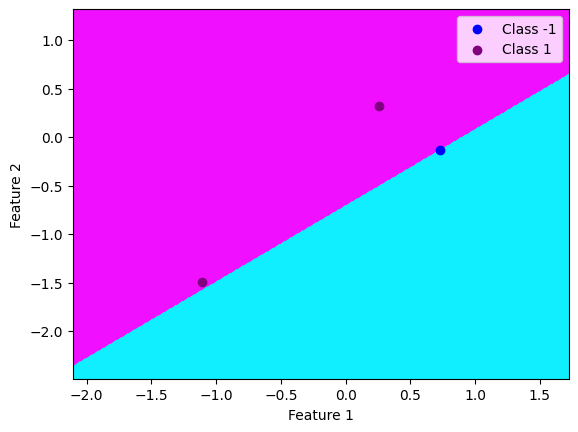

12
Training accuracy with 1.09% of the data: 0.6666666666666666


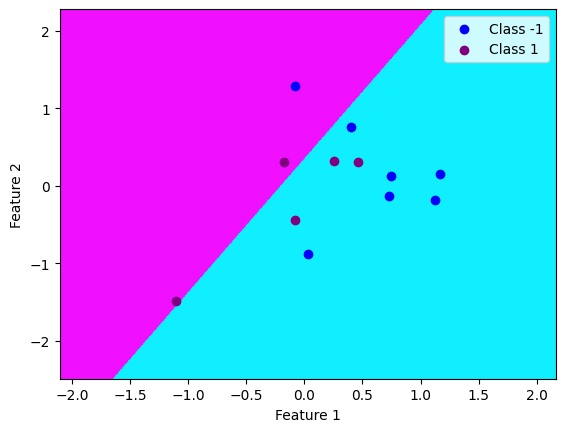

27
Training accuracy with 2.46% of the data: 0.8148148148148148


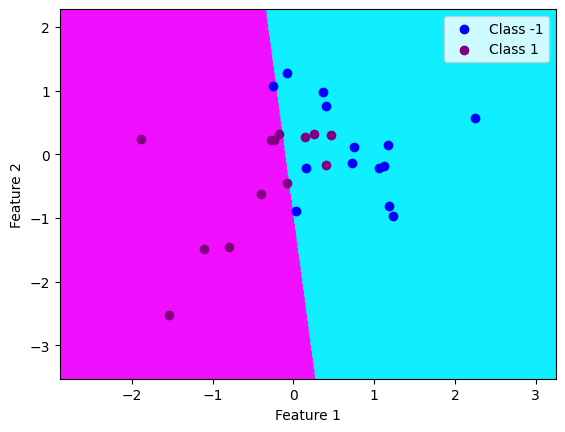

48
Training accuracy with 4.38% of the data: 0.8125


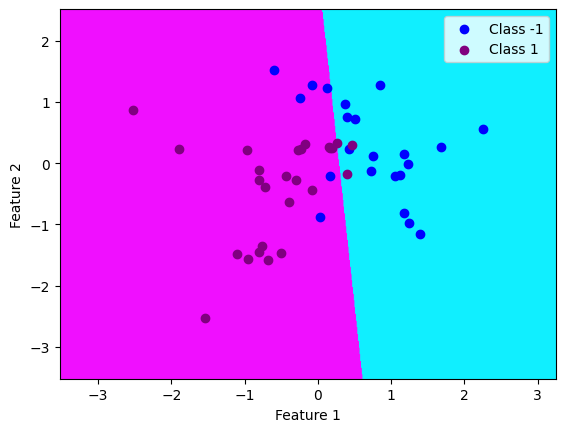

75
Training accuracy with 6.84% of the data: 0.8266666666666667


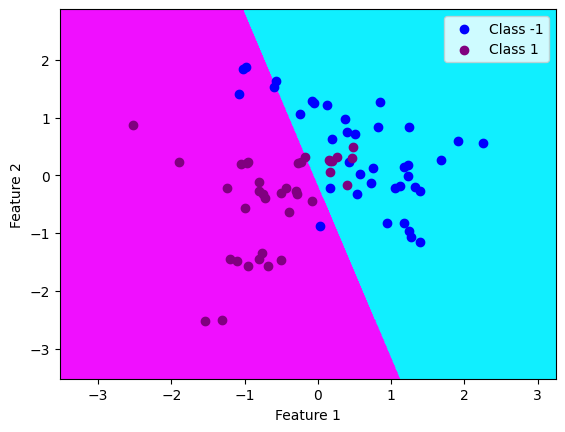

108
Training accuracy with 9.85% of the data: 0.8240740740740741


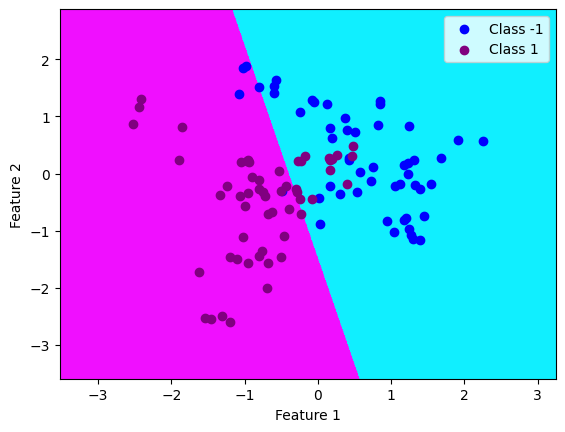

147
Training accuracy with 13.40% of the data: 0.8231292517006803


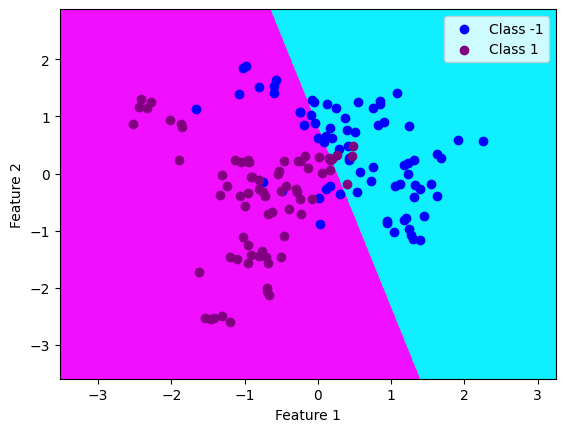

192
Training accuracy with 17.50% of the data: 0.8645833333333334


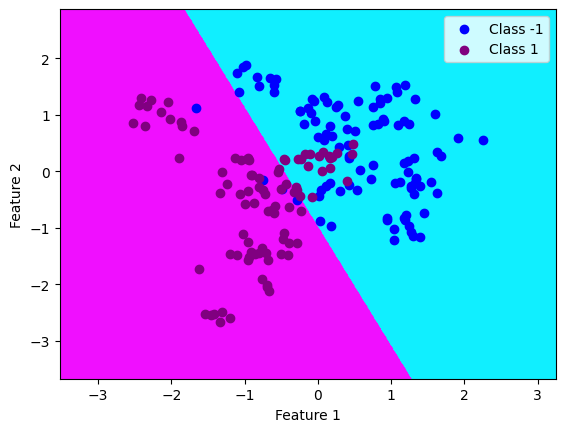

243
Training accuracy with 22.15% of the data: 0.8724279835390947


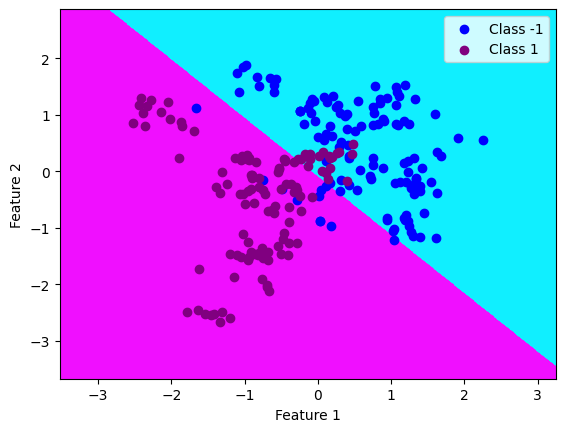

In [60]:
X_train_deleted, X_test_deleted, y_train_deleted, y_test_deleted
epochs = 4000
lr = 0.001
seed = np.random.randint(0, 1000)
w = np.random.rand(X_train_deleted.shape[1])
partition = 10
for dataSize in range(1, partition): 
    currPartition = dataSize**2 * 3
    print(currPartition)
    for epoch in range(epochs):
        for i in range(currPartition):
            x = X_train_deleted[i].T
            t = y_train[i]
            y = 1 if inference(w, x) > 0 else -1
            if t != y:
                update(w, x, t, lr)
    y_pred_train = np.array([1 if inference(w, x) > 0 else -1 for x in X_train_deleted])
    accuracy_train = accuracy(y_train[:currPartition], y_pred_train[:currPartition])
    print(f"Training accuracy with {100 * currPartition/X_train_deleted.shape[0]:.2f}% of the data:", accuracy_train)
    plot_decision_boundary(X_train_deleted[:currPartition,:], y_train[:currPartition], w)


As data is added incrementally, the decision boundary adjusts to fit the new information.  The Perceptron adapts its hyperplane, demonstrating its online learning capability.  The order of data introduction can influence the intermediate boundaries but the final boundary converges when more data represents the underlying distribution.

#### Step 5: Analyzing the Hyperplane (5 points)

After running the experiments, analyze the hyperplane’s behavior across different feature
sets and data inputs. Reflect on how the Perceptron algorithm adapts to the data and how
different feature combinations lead to different decision boundaries. Anwer the guiding
questions:
1. Why does the hyperplane change with different features or data points?
2. How does the decision boundary relate to the linearly separable nature of the data?

Answers:
1. As new data points come in the current decision boundary might not be the optimal one. So the algorithm tries to find the optimal decision boundary by updating the weights. Different features might have different distributions and different relationships with the target variable, which might lead to different decision boundaries.
2. The decision boundary is the line that separates the two classes. If the data is linearly separable, the perceptron algorithm will converge to the optimal solution, and the decision boundary will separate the two classes. If the data is not linearly separable, the perceptron algorithm will not converge, and the decision boundary will not separate the two classes.

#### Step 6: Fisher’s Linear Discriminant Projection (10 points)

In this step, you will implement Fisher’s Linear Discriminant (LD) to project the
dataset onto a 1D space and visualize the distribution of the two classes in the projected
space using a histogram. The goal of Fisher’s LD is to find the direction in the feature
space that maximizes the separation between two classes while minimizing the variance
within each class. This technique projects the data onto a single dimension where the
separation between the classes is optimized.

In [61]:
# implemented for 2 classes only 1, -1  
def fisher_ld_projection(X, y):
    y = y.reshape(-1,1)
    """Compute Fisher's Linear Discriminant projection direction."""
    # find avg points of every class
    avgClassOne = np.mean(X[y[:,0] == 1], axis=0)
    avgClassMinusOne = np.mean(X[y[:,0] == -1], axis=0)
    covarianceClassOne = np.zeros((X.shape[1], X.shape[1]))
    covarianceClassMinusOne = np.zeros((X.shape[1], X.shape[1]))
    
    # Calculate covariances manually
    for i in range(X.shape[0]):
        if y[i] == 1:
            covarianceClassOne += np.outer(X[i] - avgClassOne, X[i] - avgClassOne)
        else:
            covarianceClassMinusOne += np.outer(X[i] - avgClassMinusOne, X[i] - avgClassMinusOne)

    covariance = covarianceClassOne + covarianceClassMinusOne
    # w ∝  covariance^-1 * (avgClassOne - avgClassMinusOne)
    w = np.linalg.inv(covariance) @ (avgClassOne - avgClassMinusOne)
    # normalize
    w /= np.linalg.norm(w)
    return w

def project_data(X, direction):
    """Project data onto the Fisher LD direction."""
    return X @ direction.reshape(-1,1)

In [62]:
X_nobias = X_train_deleted[:, 1:] # Remove the bias term
direction = fisher_ld_projection(X_nobias, y_train)
# Project the data onto the Fisher LD direction
projected_data = project_data(X_nobias, direction)
projected_data.shape

(1097, 1)

While not mandatory, it can be highly instructive to visualize the projection direction computed by Fisher’s LD in the original 2D feature space. This will help you understand how the data is being projected onto a 1D space and why this direction is optimal for class separation.

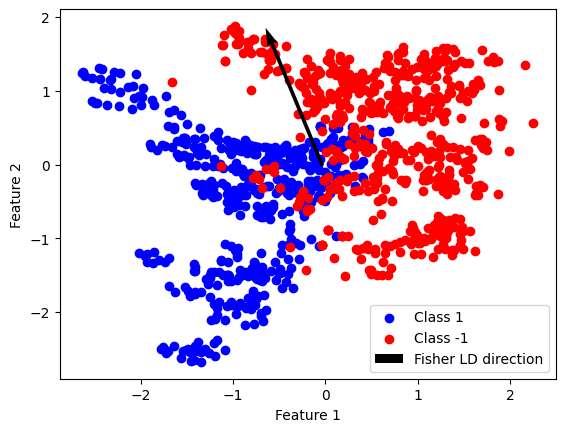

In [63]:
# Plot the 2D data with the projection direction

# Hint: You can use plt.scatter() to plot the 2D data with its features
# You can find the mean of the entire dataset for placing the direction vector
# Hint: You can use plt.quiver() method to visualize the direction vector 
# Do not forget to scale the direction vector to visualize it properly
scale = 0.3 # Adjust this to control the length of the direction line
y_train = y_train.reshape(-1)
plt.scatter(X_nobias[y_train == 1,0], X_nobias[y_train == 1,1], color='blue', label='Class 1')
plt.scatter(X_nobias[y_train == -1,0], X_nobias[y_train == -1,1], color='red', label='Class -1')
# take the orthogonal of the direction to showcase the way FDL is being projected
plt.quiver(np.mean(X_nobias[:,0]), np.mean(X_nobias[:,1]), direction[1]*scale, -direction[0]*scale, color='black', scale=1, label='Fisher LD direction')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

Plot a histogram showing the distribution of the
projected data for each class in the 1D space. The histogram will help you visualize
how well the two classes are separated by the Fisher’s LD projection.

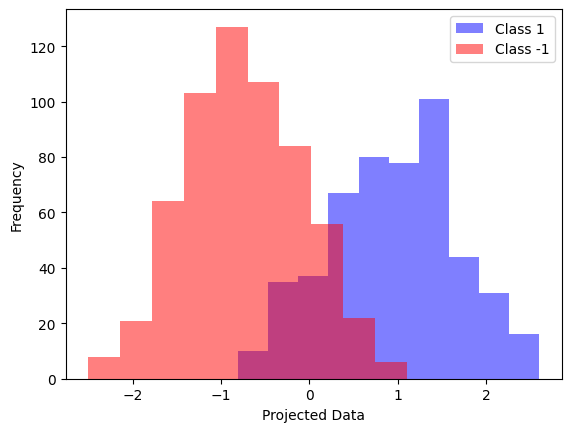

In [64]:
# Plot the histogram of the projected data
plt.hist(projected_data[y_train == 1], color='blue', alpha=0.5, label='Class 1')
plt.hist(projected_data[y_train == -1], color='red', alpha=0.5, label='Class -1')
plt.xlabel('Projected Data')
plt.ylabel('Frequency')
plt.legend()

In [65]:
maxResult = 0
# accuracy of the projected data
for bigBoundary in range(-100, 100,1):
    boundary = bigBoundary / 100
    maxClassMinusOne = np.max(projected_data[y_train == -1])
    # any class one that is less than maxClassMinusOne is misclassified
    y_pred = np.array([-1 if x < boundary else 1 for x in projected_data])
    maxResult = max(maxResult, accuracy(y_train, y_pred))
print("Max Accuracy:", maxResult)

Max Accuracy: 0.886052871467639


Answer the guiding questions:
1. How well does Fisher’s LD separate the two classes in the 1D projected space?
2. Compare the separation of the two classes in the original 2D space (used in the
Perceptron) versus the 1D Fisher’s LD projection. What do you observe about the
class distributions in these spaces?

Answer:
The histogram reveals some overlap, indicating that perfect linear separation is not achievable in this projected space. Even though Fisher's LD does not give a way to do inference, I created a mediocre script that tries to find the optimal decision boundary. It reached 88% accuracy which is better than the perceptron algorithm with 2 features.

### EXTRA: Plotting the decision boundary for higher dimensions

Initial weights: [0.70043712 0.84418664 0.67651434 0.72785806 0.95145796 0.0127032
 0.4135877 ]
Final weights: [ 0.01043712 -0.02890603 -0.05269421 -0.20859978  0.06210088 -0.61522959
  0.05982341]


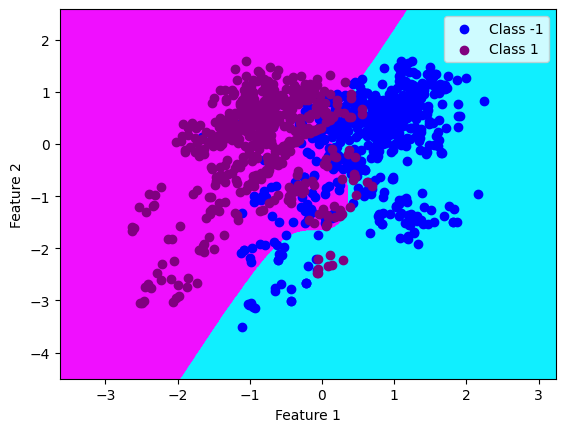

Training Accuracy: 0.8505013673655424


In [67]:
### EXTRA: plotting the graph with higher order terms
X_deleted = np.delete(X_scaled, [2, 3], axis=1)
X_train_deleted, X_test_deleted, y_train_deleted, y_test_deleted = train_test_split(X_deleted, numpy_y, test_size=0.2, random_state=1453)
new_X = np.hstack((X_train_deleted, X_train_deleted[:,1:3]**2))
new_X = np.hstack((new_X, X_train_deleted[:,1:3]**3))

extra_model = trainModel(new_X, y_train_deleted,seed=666)
def plot_decision_boundary2(X, y, model):
    # plot class 1 as blue points
    classOne = (y == 1).reshape(-1)
    classMinusOne = (y == -1).reshape(-1)

    # plot the decision boundary
    min1, max1 = X[:, 1].min()-1, X[:, 1].max()+1
    min2, max2 = X[:, 2].min()-1, X[:, 2].max()+1
    # define the x and y scale
    x1grid = np.arange(min1, max1, 0.01)
    x2grid = np.arange(min2, max2, 0.01)
    # create all of the lines and rows of the grid
    xx, yy = np.meshgrid(x1grid, x2grid)
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape(-1,1), r2.reshape(-1,1)
    # horizontal stack vectors to create x1,x2 and bias
    grid = np.hstack((np.ones((r1.shape[0],1)), r1, r2, r1**2, r2**2, r1**3, r2**3))
    # make predictions
    predictions = np.array([1 if inference(model, x) > 0 else -1 for x in grid])
    # reshape the predictions back into a grid
    zz = predictions.reshape(xx.shape)
    # plot the grid of x, y and z values as a surface
    plt.contourf(xx, yy, zz, cmap='cool')  

    # Scatter plots for each class with cool colors
    plt.scatter(X[classMinusOne][:, 1], X[classMinusOne][:, 2], color='blue', label='Class -1')  # Set color to purple for Class -1
    plt.scatter(X[classOne][:, 1], X[classOne][:, 2], color='purple', label='Class 1')      # Set color to blue for Class 1
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

plot_decision_boundary2(new_X, y_train_deleted, extra_model)
# print the accuracy
y_pred_train_deleted = np.array([1 if inference(extra_model, x) > 0 else -1 for x in new_X])
accuracy_train_deleted = accuracy(y_train_deleted, y_pred_train_deleted)
print("Training Accuracy:", accuracy_train_deleted)

Since the dataset was almost linearly seperable perceptron algorithm was able to achieve high score. But if there was non linear relationship between the features, perceptron algorithm would not be able to achieve high scores. In such cases, we can use non-linear models or we can use polynomial features to make the model more complex.